# Predicting  extreme monsoon rainfall  

###  Model ConvLSTM2d

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop

##### Reading data from local repo

In [4]:
march_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\march\data_stream-oper_stepType-instant.nc")
march_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\march\data_stream-oper_stepType-accum.nc")
april_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\april\data_stream-oper_stepType-instant.nc")
april_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\april\data_stream-oper_stepType-accum.nc")
may_aug_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\may_august\data_stream-oper_stepType-instant.nc")
may_aug_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\may_august\data_stream-oper_stepType-accum.nc")
sep_dec_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\sep_dec\data_stream-oper_stepType-instant.nc")
sep_dec_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\sep_dec\data_stream-oper_stepType-accum.nc")

##### concatenate  all data

In [6]:
datasets_data = [march_data, april_data, may_aug_data, sep_dec_data]
datasets_prep = [march_prep, april_prep, may_aug_prep, sep_dec_prep]
# Concatenate along valid_time
all_data = xr.concat(datasets_data, dim="valid_time")
all_prep = xr.concat(datasets_prep, dim="valid_time")

In [7]:
temperature_2m = all_data['t2m']
sea_level_pressure = all_data['msl']
sea_surface_temp = all_data['sst']
eastward_water_vapour_flux = all_data['viwve']
northward_water_vapour_flux = all_data['viwvn']
precipitation = all_prep['tp']

###### Replace NaN values in sea_surface_temp with t2m values

In [8]:
# Replace NaN values in sea_surface_temp with t2m values
sea_surface_temp_filled = sea_surface_temp.fillna(temperature_2m)

###### Generate complete hourly time range 

In [9]:
# Generate complete hourly time range
full_time_range = pd.date_range(
    start='2004-03-01 00:00:00',
    end='2004-12-30 23:00:00', 
    freq='h'
)

# Regularize ALL variables with forward fill
precipitation_regular = precipitation.reindex(valid_time=full_time_range, method='ffill')
sea_level_pressure_regular = sea_level_pressure.reindex(valid_time=full_time_range, method='ffill')
sea_surface_temp_filled_regular = sea_surface_temp_filled.reindex(valid_time=full_time_range, method='ffill')
eastward_water_vapour_flux_regular = eastward_water_vapour_flux.reindex(valid_time=full_time_range, method='ffill')
northward_water_vapour_flux_regular = northward_water_vapour_flux.reindex(valid_time=full_time_range, method='ffill')

# Print shapes to verify
print("Shapes after regularization:")
print(f"Precipitation: {precipitation_regular.valid_time.shape}")
print(f"Sea level pressure: {sea_level_pressure_regular.valid_time.shape}")
print(f"SST: {sea_surface_temp_filled_regular.valid_time.shape}")
print(f"Eastward flux: {eastward_water_vapour_flux_regular.valid_time.shape}")
print(f"Northward flux: {northward_water_vapour_flux_regular.valid_time.shape}")


# Check if we still have NaN values
print("NaN counts after forward fill reindexing:")
print(f"Precipitation: {precipitation_regular.isnull().sum().item()}")
print(f"Sea level pressure: {sea_level_pressure_regular.isnull().sum().item()}")
print(f"SST: {sea_surface_temp_filled_regular.isnull().sum().item()}")
print(f"Eastward flux: {eastward_water_vapour_flux_regular.isnull().sum().item()}")
print(f"Northward flux: {northward_water_vapour_flux_regular.isnull().sum().item()}")

Shapes after regularization:
Precipitation: (7320,)
Sea level pressure: (7320,)
SST: (7320,)
Eastward flux: (7320,)
Northward flux: (7320,)
NaN counts after forward fill reindexing:
Precipitation: 0
Sea level pressure: 0
SST: 0
Eastward flux: 0
Northward flux: 0


In [10]:
# Resample all regularized variables
precipitation_total = precipitation_regular.resample(valid_time='1D').sum()
sea_level_pressure_mean = sea_level_pressure_regular.resample(valid_time='1D').mean()
sea_surface_temp_filled_mean = sea_surface_temp_filled_regular.resample(valid_time='1D').mean()
eastward_water_vapour_flux_mean = eastward_water_vapour_flux_regular.resample(valid_time='1D').mean()
northward_water_vapour_flux_mean = northward_water_vapour_flux_regular.resample(valid_time='1D').mean()

# Check for NaN values in all resampled variables
print("\nNaN counts after regularization and resampling:")
print(f"Precipitation: {precipitation_total.isnull().sum().item()}")
print(f"Sea level pressure: {sea_level_pressure_mean.isnull().sum().item()}")
print(f"SST: {sea_surface_temp_filled_mean.isnull().sum().item()}")
print(f"Eastward flux: {eastward_water_vapour_flux_mean.isnull().sum().item()}")
print(f"Northward flux: {northward_water_vapour_flux_mean.isnull().sum().item()}")


NaN counts after regularization and resampling:
Precipitation: 0
Sea level pressure: 0
SST: 0
Eastward flux: 0
Northward flux: 0


In [11]:
# --- Combine all required features into one Dataset ---
ds_all = xr.Dataset({
    'tp': precipitation_total,
    'msl': sea_level_pressure_mean,
    'sst': sea_surface_temp_filled_mean,
    'Qu': eastward_water_vapour_flux_mean,
    'Qv': northward_water_vapour_flux_mean,
})

In [33]:
ds_all

<xarray.Dataset> Size: 83MB
Dimensions:     (latitude: 121, longitude: 113, valid_time: 305)
Coordinates:
  * latitude    (latitude) float64 968B 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 904B 72.0 72.25 72.5 ... 99.5 99.75 100.0
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2004-03-01 ... 2004-12-30
Data variables:
    tp          (valid_time, latitude, longitude) float32 17MB 0.0 ... 0.002824
    msl         (valid_time, latitude, longitude) float32 17MB 1.014e+05 ... ...
    sst         (valid_time, latitude, longitude) float32 17MB 294.0 ... 298.0
    Qu          (valid_time, latitude, longitude) float32 17MB 23.94 ... -30.31
    Qv          (valid_time, latitude, longitude) float32 17MB -19.62 ... -213.8

#### Normalize data according to grid (z-score)

In [12]:
def zscore_gridwise(da):
    mean_ = da.mean(dim="valid_time", skipna=True)
    std_  = da.std(dim="valid_time", skipna=True)
    std_nonzero = std_.where(std_ > 0)
    return (da - mean_) / std_nonzero


In [13]:
tp_zscore  = zscore_gridwise(precipitation_total)
msl_zscore = zscore_gridwise(sea_level_pressure_mean)
sst_zscore = zscore_gridwise(sea_surface_temp_filled_mean)
Qu_zscore  = zscore_gridwise(eastward_water_vapour_flux_mean)
Qv_zscore  = zscore_gridwise(northward_water_vapour_flux_mean)

ds_scaled = xr.Dataset({
    'tp': tp_zscore,
    'msl': msl_zscore,
    'sst': sst_zscore,
    'Qu': Qu_zscore,
    'Qv': Qv_zscore,
})


In [14]:
feature_vars = ["tp", "msl", "sst", "Qu", "Qv"]

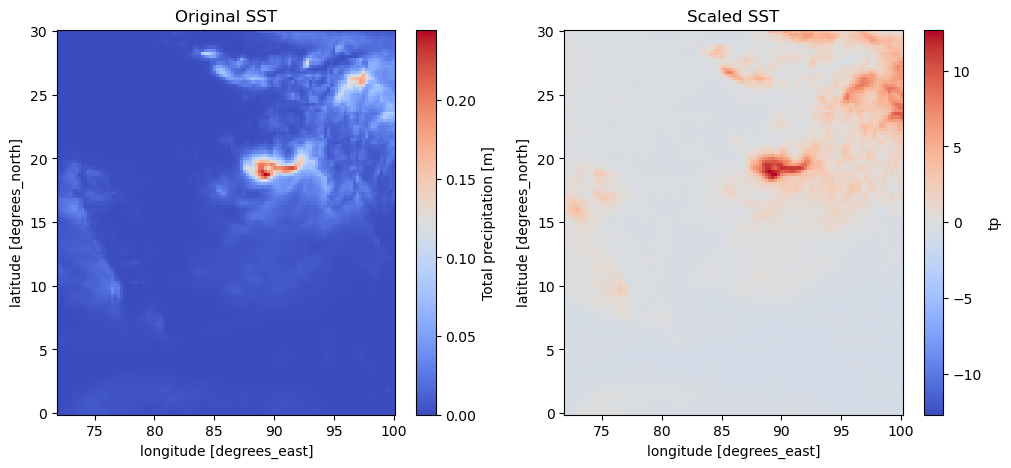

In [15]:
t = 78  # day index to visualize

fig, axs = plt.subplots(1, 2, figsize=(12,5))
ds_all["tp"].isel(valid_time=t).plot(ax=axs[0], cmap="coolwarm")
axs[0].set_title("Original SST")

ds_scaled["tp"].isel(valid_time=t).plot(ax=axs[1], cmap="coolwarm")
axs[1].set_title("Scaled SST")

plt.show()


**“In this setup, the lookback window is 15 days and the lead time is 1 day. The model uses the past 15 days of data (precipitation, sea_level_pressure, sea_surface_temp_filled, eastward_water_vapour_flux, northward_water_vapour_flux) to predict the precipitation for the next day.”**


In [16]:
lookback = 15
lead_time = 1

time = ds_scaled.valid_time.values
n = len(time)

feature_vars = ['tp', 'msl', 'sst', 'Qu', 'Qv']

samples = []
targets = []

for i in range(n - lookback - lead_time):
    X_list = []

    for var in feature_vars:
        # Extract (lookback, lat, lon) window
        X_var = ds_scaled[var].isel(valid_time=slice(i, i + lookback)).values

        X_list.append(X_var)

    # Stack features into (lookback, lat, lon, variables)
    X_window = np.stack(X_list, axis=-1)

    # Target → tp at (i + lookback + lead_time - 1)
    y = ds_all['tp'].isel(valid_time=i + lookback + lead_time - 1).values

    samples.append(X_window)
    targets.append(y)

# Final numpy arrays
X_np = np.stack(samples)
y_np = np.stack(targets)

# Train/val split
split_idx = int(0.8 * len(X_np))
X_train = X_np[:split_idx]
y_train = y_np[:split_idx]
X_val = X_np[split_idx:]
y_val = y_np[split_idx:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (231, 15, 121, 113, 5)
y_train shape: (231, 121, 113)


In [17]:
# --- GET INPUT/OUTPUT SHAPES ---
# Get sample to determine shapes

input_shape = X_train.shape[1:]  # (timesteps, lat, lon, features)
output_shape = y_train.shape[1:]  # (lat, lon, 1)

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")

Input shape: (15, 121, 113, 5)
Output shape: (121, 113)


In [18]:
# Reduce batch size and model complexity
model = models.Sequential()

# First ConvLSTM2D with fewer filters
model.add(layers.ConvLSTM2D(
    filters=16,  # Reduced from 64
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    input_shape=input_shape,
    activation='relu'
))

# Add batch normalization
model.add(layers.BatchNormalization())

# Second ConvLSTM2D
model.add(layers.ConvLSTM2D(
    filters=32,  # Reduced from 64
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    activation='relu'
))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(1, (1, 1), padding='same', activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
# Train with smaller batch size
history = model.fit(
    X_train, y_train,
    batch_size=2,  # Reduced from 16
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
116/116 [==============================] - 104s 370ms/step - loss: 0.2890 - mae: 0.2744 - val_loss: 0.0190 - val_mae: 0.1105
Epoch 2/10
116/116 [==============================] - 41s 351ms/step - loss: 0.0260 - mae: 0.0979 - val_loss: 0.0034 - val_mae: 0.0406
Epoch 3/10
116/116 [==============================] - 39s 340ms/step - loss: 0.0120 - mae: 0.0684 - val_loss: 0.0106 - val_mae: 0.0700
Epoch 4/10
116/116 [==============================] - 39s 338ms/step - loss: 0.0069 - mae: 0.0532 - val_loss: 0.0064 - val_mae: 0.0548
Epoch 5/10
116/116 [==============================] - 39s 335ms/step - loss: 0.0046 - mae: 0.0433 - val_loss: 0.0060 - val_mae: 0.0586
Epoch 6/10
116/116 [==============================] - 40s 347ms/step - loss: 0.0035 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0438
Epoch 7/10
116/116 [==============================] - 39s 335ms/step - loss: 0.0028 - mae: 0.0343 - val_loss: 0.0040 - val_mae: 0.0482
Epoch 8/10
116/116 [==============================] - 

In [20]:
# Make predictions
y_pred = model.predict(X_val)

2/2 [==============================] - 2s 877ms/step


In [21]:
# Remove the last dimension from y_pred 
y_pred_2d = y_pred.squeeze()

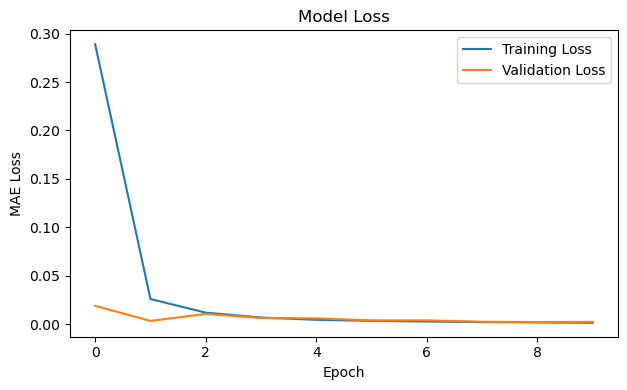

In [31]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.tight_layout()
plt.show()

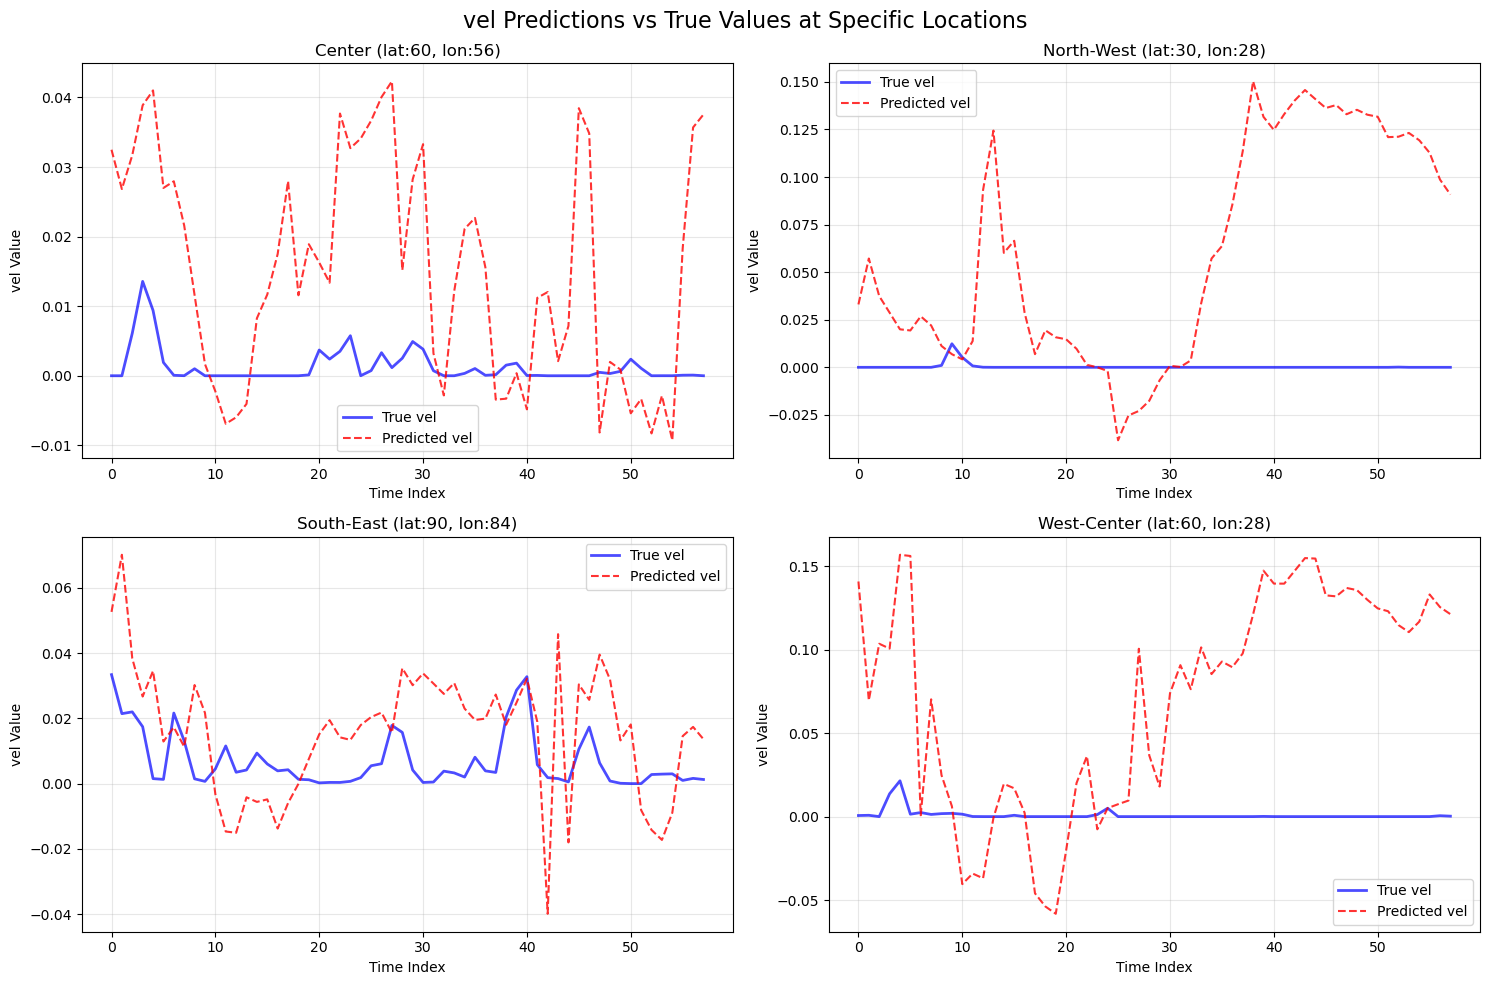

In [35]:
# Plot time series for specific grid points
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('vel Predictions vs True Values at Specific Locations', fontsize=16)
n_lat = 121
n_lon = 113
# Choose some specific locations to monitor
locations = [
    (n_lat//2, n_lon//2),      # Center point
    (n_lat//4, n_lon//4),      # NW quadrant
    (3*n_lat//4, 3*n_lon//4),  # SE quadrant
    (n_lat//2, n_lon//4)       # West center
]

location_names = ['Center', 'North-West', 'South-East', 'West-Center']

for idx, ((lat_idx, lon_idx), name) in enumerate(zip(locations, location_names)):
    ax = axes[idx//2, idx%2]
    
    # Plot true vs predicted for this location across all validation samples
    time_points = range(len(y_val))
    ax.plot(time_points, y_val[:, lat_idx, lon_idx], 
            'b-', label='True vel', alpha=0.7, linewidth=2)
    ax.plot(time_points, y_pred_2d[:, lat_idx, lon_idx], 
            'r--', label='Predicted vel', alpha=0.8, linewidth=1.5)
    
    ax.set_title(f'{name} (lat:{lat_idx}, lon:{lon_idx})')
    ax.set_xlabel('Time Index')
    ax.set_ylabel('vel Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

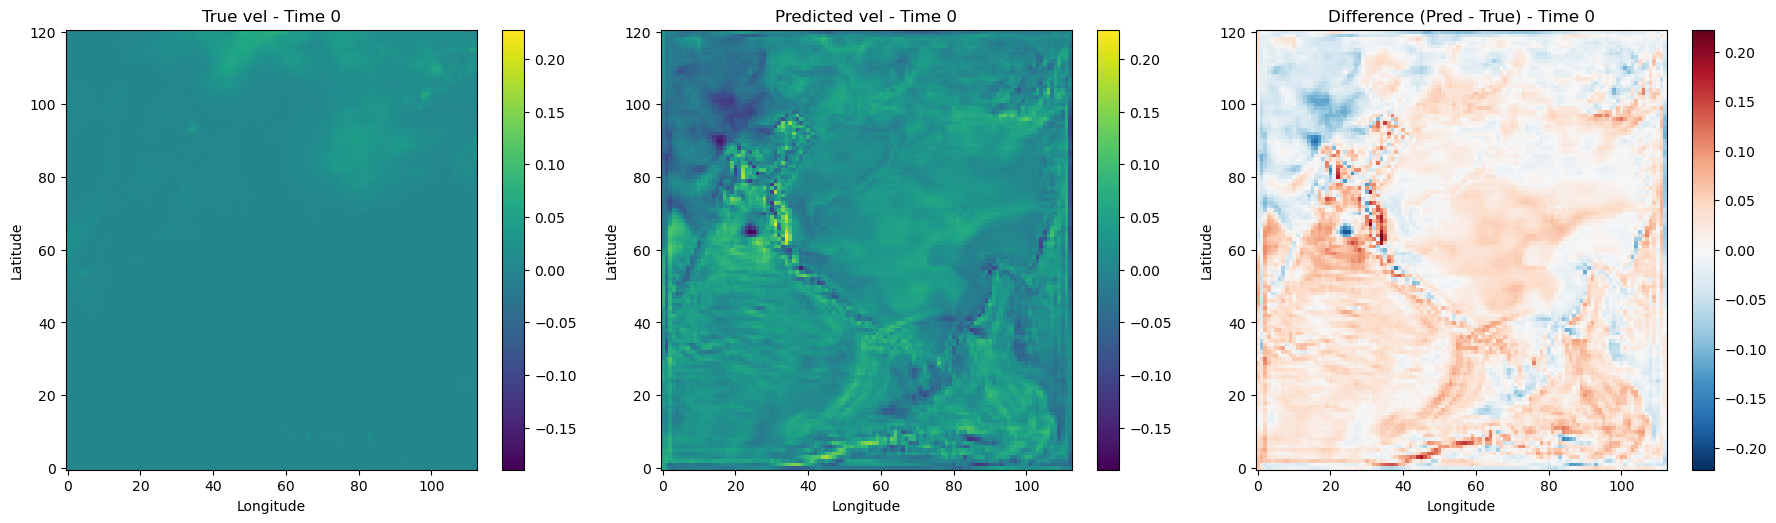

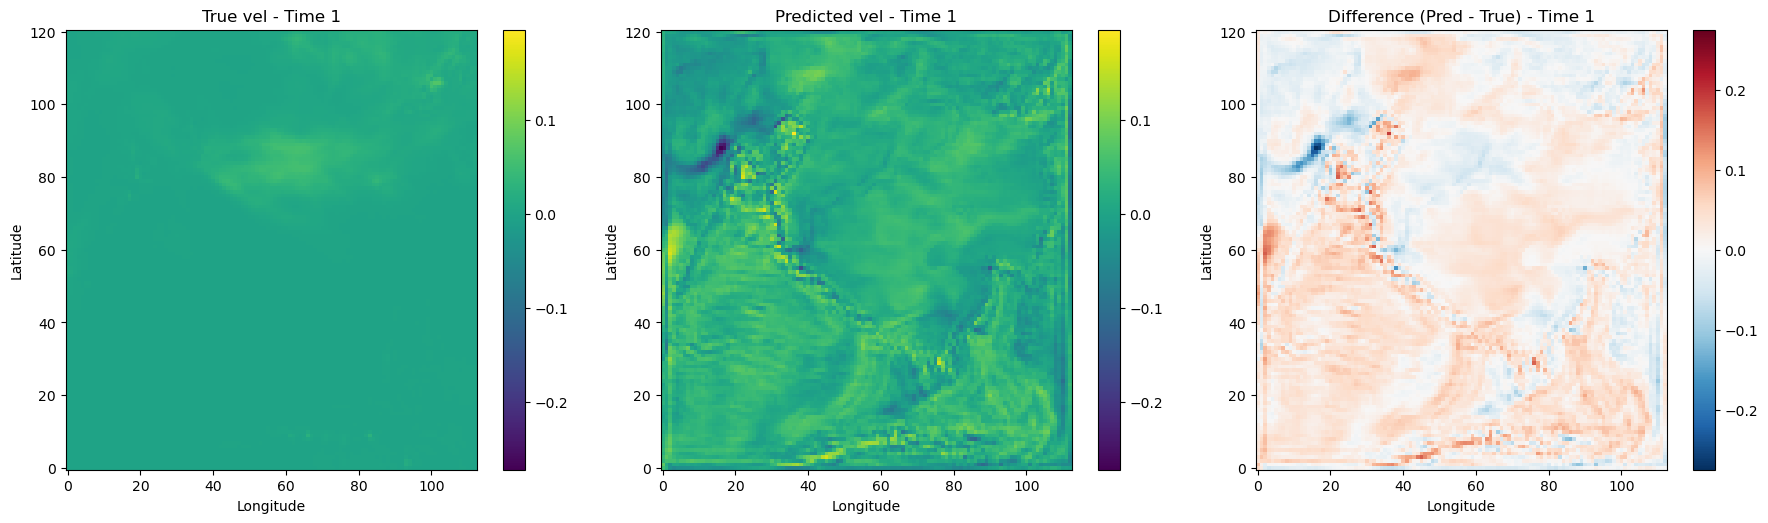

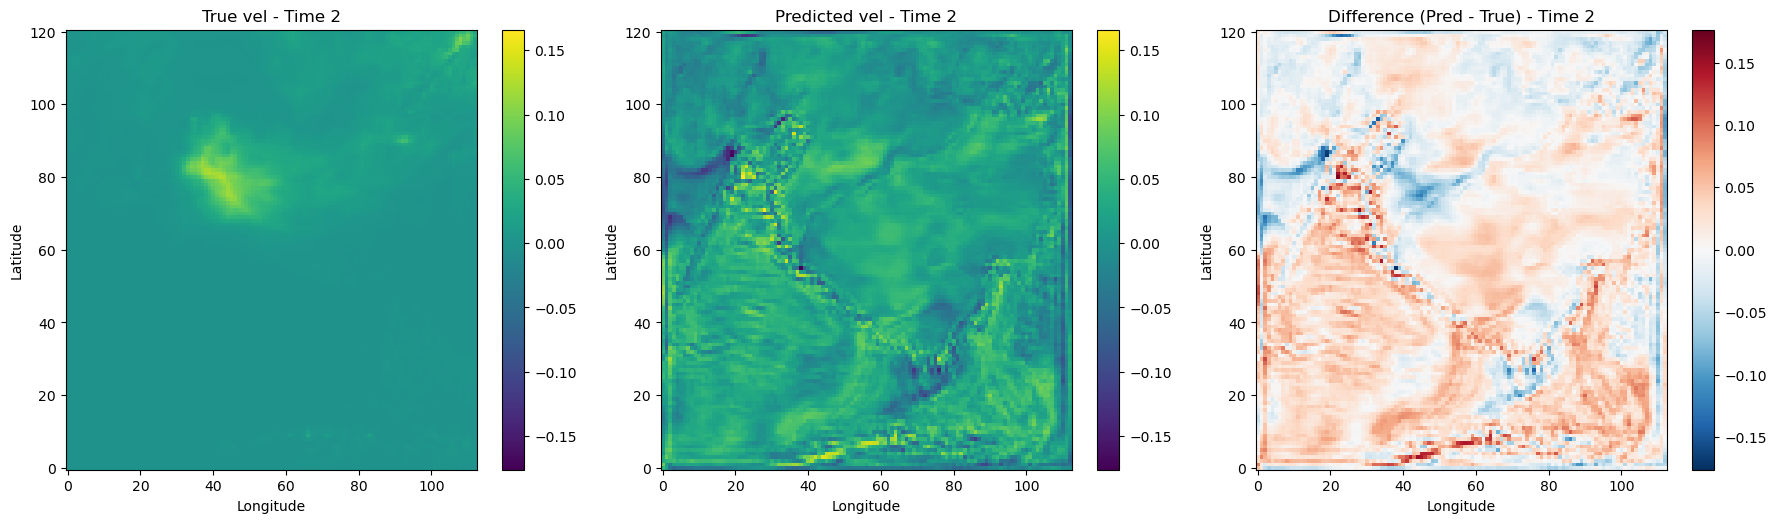

In [38]:
# Plot spatial maps for specific time steps
def plot_spatial_comparison(time_idx, vmin=None, vmax=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    if vmin is None:
        vmin = min(y_val[time_idx].min(), y_pred_2d[time_idx].min())
    if vmax is None:
        vmax = max(y_val[time_idx].max(), y_pred_2d[time_idx].max())
    
    # True values
    im1 = ax1.imshow(y_val[time_idx], cmap='viridis', 
                     vmin=vmin, vmax=vmax, origin='lower')
    ax1.set_title(f'True vel - Time {time_idx}')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1)
    
    # Predicted values
    im2 = ax2.imshow(y_pred_2d[time_idx], cmap='viridis', 
                     vmin=vmin, vmax=vmax, origin='lower')
    ax2.set_title(f'Predicted vel - Time {time_idx}')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2)
    
    # Difference (Error)
    diff = y_pred_2d[time_idx] - y_val[time_idx]
    im3 = ax3.imshow(diff, cmap='RdBu_r', 
                     vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), 
                     origin='lower')
    ax3.set_title(f'Difference (Pred - True) - Time {time_idx}')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    plt.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
    return diff

# Plot for first few time steps
for i in range(min(3, len(y_val))):
    diff = plot_spatial_comparison(i)

#### 1. Basic Statistical Metrics

###### Calculate Multiple Accuracy Metrics

In [24]:
def calculate_all_metrics(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    
    metrics = {}
    
    # Basic regression metrics
    metrics['mse'] = mean_squared_error(y_true, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    
    # Additional metrics
    metrics['bias'] = np.mean(y_pred - y_true)
    metrics['mape'] = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    
    # Skill scores (compared to persistence forecast)
    persistence_pred = np.roll(y_true, 1)  # Simple persistence forecast
    persistence_pred[0] = y_true[0]
    metrics['skill_score'] = 1 - (metrics['mse'] / mean_squared_error(y_true, persistence_pred))
    
    # Correlation
    metrics['pearson_corr'] = np.corrcoef(y_true, y_pred)[0, 1]
    
    return metrics

# Calculate all metrics
metrics = calculate_all_metrics(y_val_clean, y_pred_clean)

print("📊 COMPREHENSIVE MODEL EVALUATION:")
print("=" * 50)
for metric, value in metrics.items():
    print(f"{metric.upper():<15}: {value:.4f}")

📊 COMPREHENSIVE MODEL EVALUATION:
MSE            : 0.0024
RMSE           : 0.0495
MAE            : 0.0359
R2             : -40.0066
BIAS           : 0.0190
MAPE           : 171591025.0000
SKILL_SCORE    : -561.1833
PEARSON_CORR   : -0.1066


###### Scatter Plots and Distribution Analysis

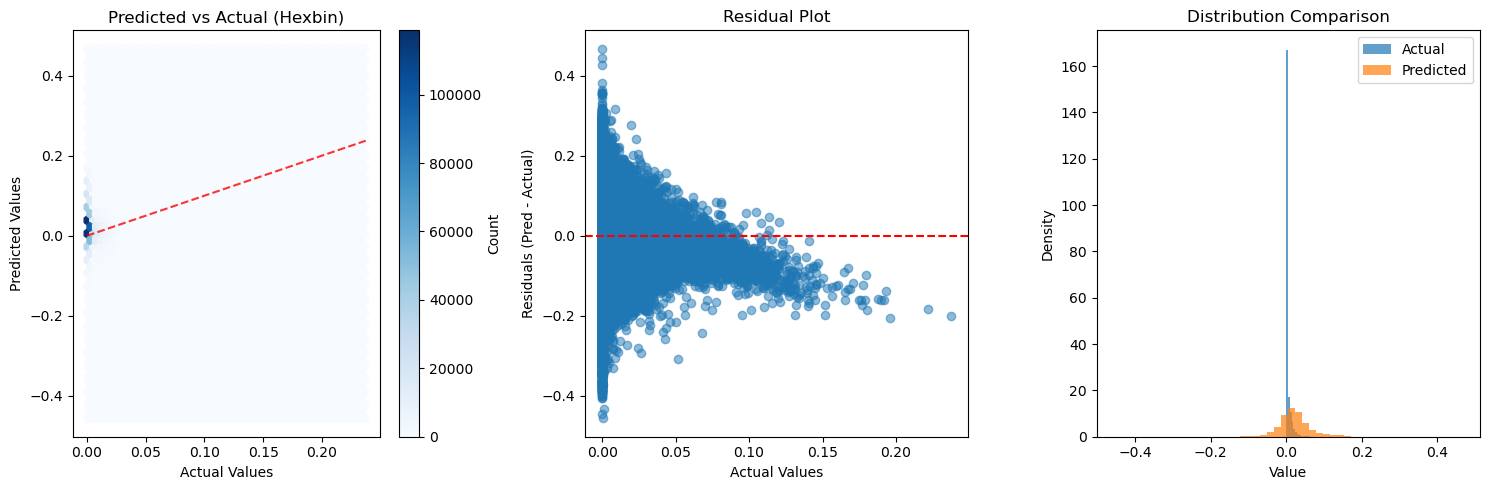

In [40]:
# Scatter plot with density
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hexbin(y_val_clean, y_pred_clean, gridsize=50, cmap='Blues')
plt.plot([y_val_clean.min(), y_val_clean.max()], [y_val_clean.min(), y_val_clean.max()], 'r--', alpha=0.8)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual (Hexbin)')
plt.colorbar(label='Count')

# Residual plot
plt.subplot(1, 3, 2)
residuals = y_pred_clean - y_val_clean
plt.scatter(y_val_clean, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Pred - Actual)')
plt.title('Residual Plot')

# Distribution comparison
plt.subplot(1, 3, 3)
plt.hist(y_val_clean, bins=50, alpha=0.7, label='Actual', density=True)
plt.hist(y_pred_clean, bins=50, alpha=0.7, label='Predicted', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.tight_layout()
plt.show()

###### Mean Spatial Patterns

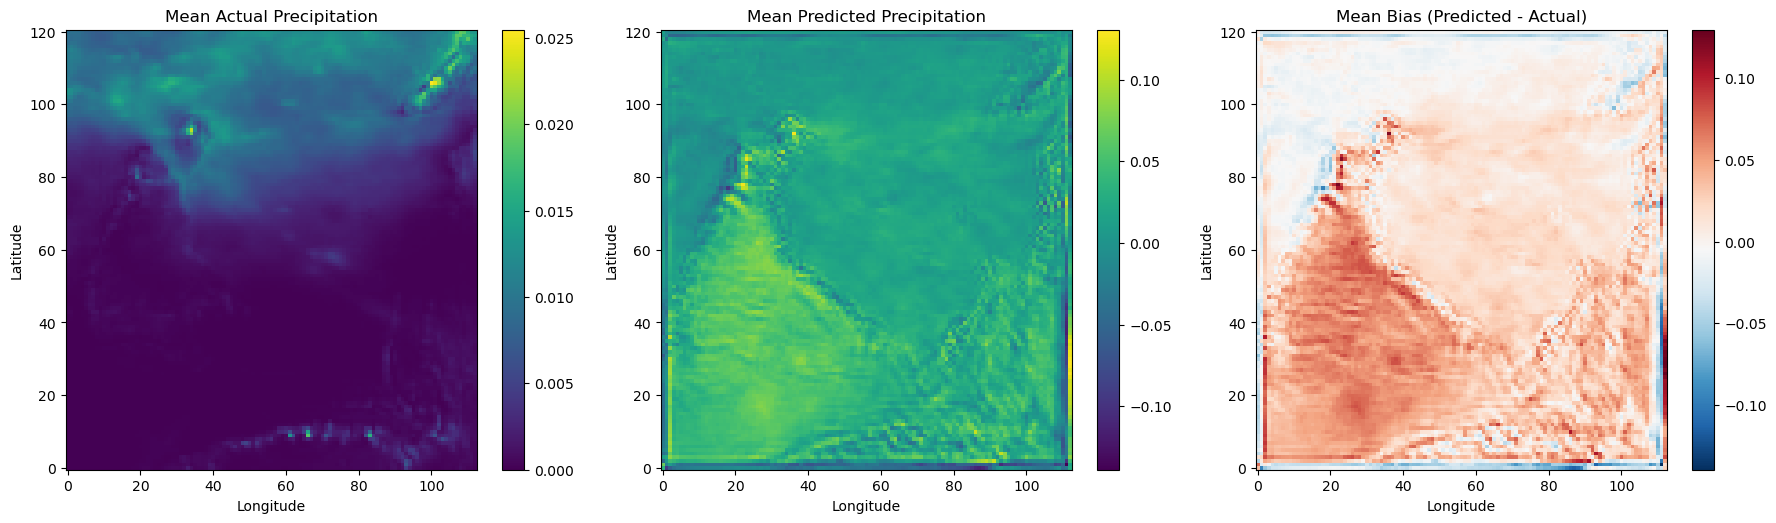

Global Mean Actual: 0.0034
Global Mean Predicted: 0.0224
Global Mean Bias: 0.0190


In [41]:
# Calculate mean patterns
mean_actual = np.mean(y_val, axis=0)
mean_predicted = np.mean(y_pred_2d, axis=0)
mean_bias = mean_predicted - mean_actual

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean Actual
im1 = axes[0].imshow(mean_actual, cmap='viridis', origin='lower')
axes[0].set_title('Mean Actual Precipitation')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0])

# Mean Predicted
im2 = axes[1].imshow(mean_predicted, cmap='viridis', origin='lower')
axes[1].set_title('Mean Predicted Precipitation')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[1])

# Mean Bias
im3 = axes[2].imshow(mean_bias, cmap='RdBu_r', origin='lower')
axes[2].set_title('Mean Bias (Predicted - Actual)')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"Global Mean Actual: {mean_actual.mean():.4f}")
print(f"Global Mean Predicted: {mean_predicted.mean():.4f}")
print(f"Global Mean Bias: {mean_bias.mean():.4f}")

###### Quantile-Quantile Plot by Location

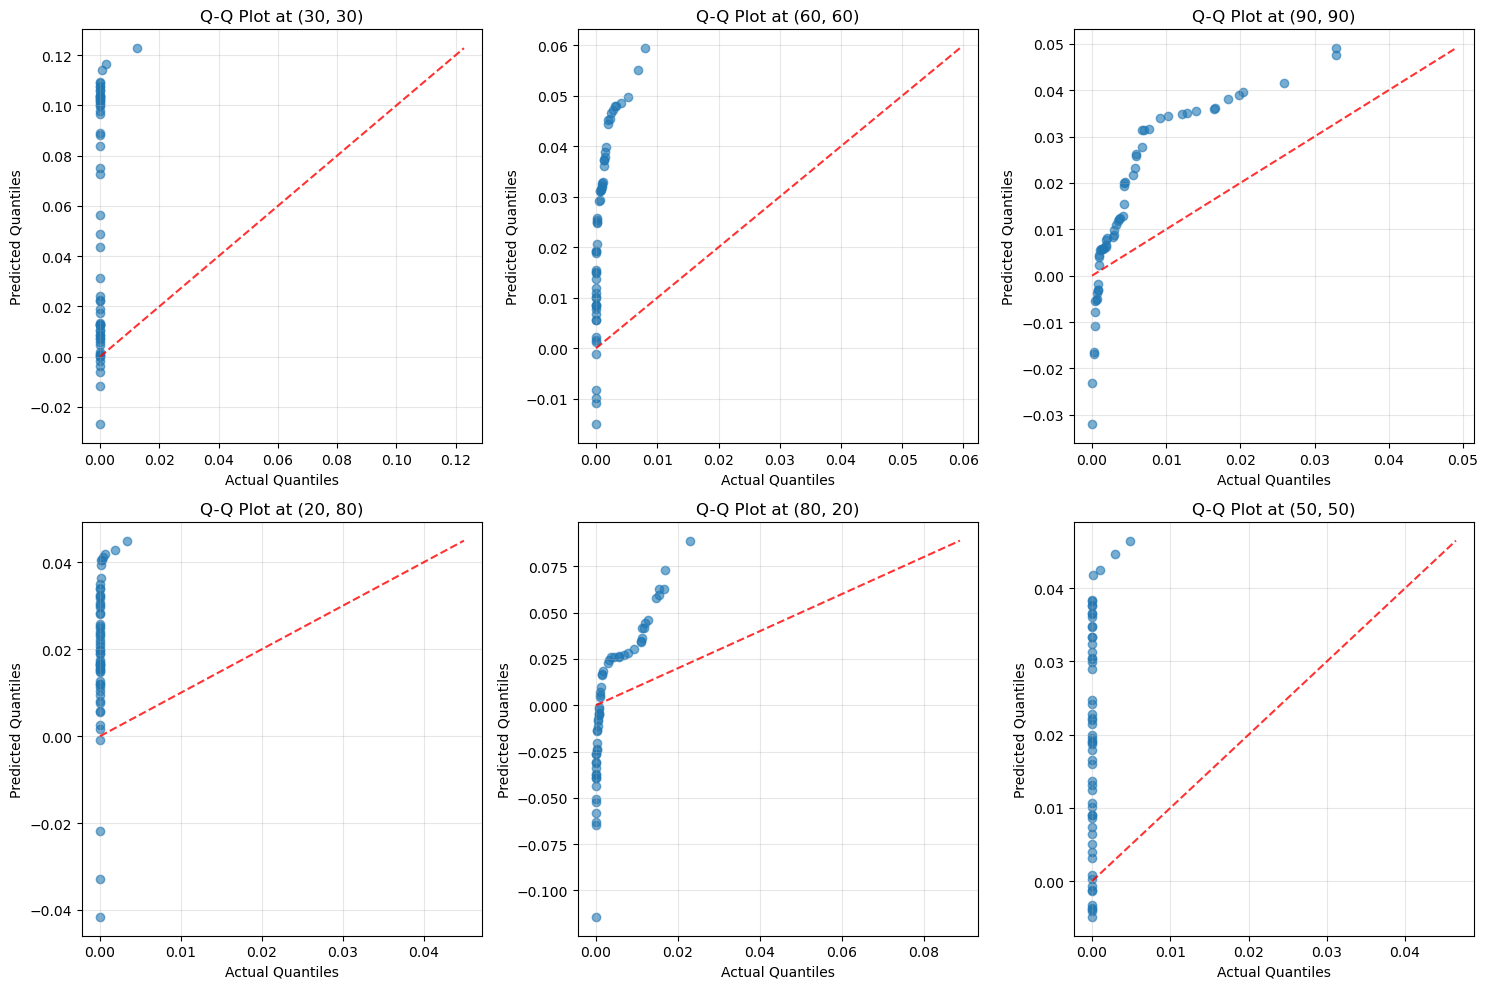

In [42]:
# Q-Q plots for different locations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
locations = [
    (30, 30), (60, 60), (90, 90),  # Three points
    (20, 80), (80, 20), (50, 50)   # Three more points
]

for idx, (lat, lon) in enumerate(locations):
    row = idx // 3
    col = idx % 3
    
    actual_ts = y_val[:, lat, lon]
    pred_ts = y_pred_2d[:, lat, lon]
    
    # Sort values for Q-Q plot
    actual_sorted = np.sort(actual_ts)
    pred_sorted = np.sort(pred_ts)
    
    axes[row, col].scatter(actual_sorted, pred_sorted, alpha=0.6)
    max_val = max(actual_sorted.max(), pred_sorted.max())
    axes[row, col].plot([0, max_val], [0, max_val], 'r--', alpha=0.8)
    axes[row, col].set_xlabel('Actual Quantiles')
    axes[row, col].set_ylabel('Predicted Quantiles')
    axes[row, col].set_title(f'Q-Q Plot at ({lat}, {lon})')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()